# 1. Introduction
In this script, we build a multi-linear regression model to characterize linear relations between sea surface temperature (SST) and several climate variables over different regions in Antarctica.
## 1.1 Background

The linear relation between climate variables and SST can be represented by "GTO"

\begin{equation*}
R(x) = \int_{A'}G(x,x')T(x')dA'+\varepsilon(x)
\end{equation*}


* Item
  * small item

The followings are the steps to generate/visualize GTO maps for Antarctica:
* Step 1. Read in climatological SST
* Step 2. Read in 1k perturbed SST fields and calculate SST deviation from the climatological sst ($\Delta SST$)
* Step 3. Read in 1k perturbed CAM output
* Step 4. Read in control CAM output
* Step 5. Calculate $\Delta R$ (response) by substracting control results from perturbed results and apply areal-average over regions of interest
* Step 6. Calculate sensitivity (K) of particular climate variables to perturbed SST using ordinary least squares (OLS)
* Step 7. Perform two-tailed student-t test at 10% significance level against the K
* Step 8. Plot GTO maps

# 2. Data
* Perturbed SST fields (1k ensemble members)
* Perturbed CAM output (1k ensemble members) 
* Control CAM output 

In [25]:
#This script calculates and plots the GTO based on the NCAR CESM specified below

In [2]:
# Import libraries
import numpy as np
import numpy.ma as ma
import matplotlib as mpl
import matplotlib.pyplot as plt
import netCDF4 as net4
from mpl_toolkits.basemap import Basemap, addcyclic, shiftgrid
from pylab import *
import matplotlib.backends.backend_pdf
import statsmodels
import statsmodels.api as sm

np.set_printoptions(threshold='nan',precision=3)

/woju/s0/cxt334/Python/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
# Define a function for calculating seasonal mean
def month_to_season(data,seasonN):
    if seasonN == 'DJF':
        DDec = data[11,:,:]
        DJan = data[0,:,:]
        DFeb = data[1,:,:]
        sea_mean = (DDec*31.0 + DJan*31.0 + DFeb*28.0)/(31.0+31.0+28.0)
    elif seasonN == 'MAM':
        sea_mean = np.average(data[2:5,:,:],axis=0,weights=[31.0/(31.0+30.0+31.0),30.0/(31.0+30.0+31.0),31.0/(31.0+30.0+31.0)])
    elif seasonN == 'JJA':
        sea_mean = np.average(data[5:8,:,:],axis=0,weights=[30.0/(30.0+31.0+31.0),31.0/(30.0+31.0+31.0),31.0/(30.0+31.0+31.0)])
    else:           #SON
        sea_mean = np.average(data[8:11,:,:],axis=0,weights=[30.0/(30.0+31.0+30.0),31.0/(30.0+31.0+30.0),30.0/(30.0+31.0+30.0)])

    return sea_mean

In [4]:
# User defined variables/Regions of interest
print 'Defining variables/regions'
season = 'DJF'  # season, data type:string  #, 'MAM', 'JJA', 'SON'
num_ens= 1000   # number of ensemble members
version= '3.1'  # CAM version
#re     = 'ANT'  # name of region of interest
GR     = ['ANT (61S-90S, 0-360)',
          'EA  (66S-90S, 0-180&330-360)',
          'WA  (65S-90S, 180-330)',
          'AMD (70S-80S, 230-260)',
          'PEN (61S-75S ,285-305)']
GRS    = ['ANT','EA','WA','AMD','PEN']
Var    = ['T2m','T700','PRECIP','SLP','H500','H200']

Defining variables/regions


In [5]:
# Read in climatological SST boundary conditions BC
w0 = net4.Dataset('/mizuna/s0/cxt334/Research/GTOwork_Polar/RPM_Extended/WeiFiles/inputdatasst/sst_HadOIBl_bc_1.9x2.5_clim_c061031.nc','r')

# Read in lat/lon into allocate matrics
lon  = w0.variables['lon'][:]
lat  = w0.variables['lat'][:]
sst0 = w0.variables['SST_cpl'][:]
nlon = lon.shape[0]  #[0] for tuple to integer
nlat = lat.shape[0]

w0.close()

sst_sn_en  = np.empty([num_ens,nlat,nlon])*np.nan
t_grregion = np.empty([num_ens,len(GRS),len(Var)])*np.nan

In [6]:
# Read in perturbed SST fields & CAM output
fil = '/mizuna/s0/cxt334/Research/GTOwork_Polar/RPM_Extended/'
nm = 1
while nm <= num_ens:
      print 'ens =',nm
      #************************************************
      # Read in perturbed SST field
      #************************************************
      w1  = net4.Dataset(fil+'WeiFiles/CAM'+version+'/sst/sst_HadOIBl_bc_1.9x2.5_clim_pert'+str(nm)+'_c061031.nc','r')
      sst = w1.variables['SST_cpl'][:]
      sst = sst-sst0   # delta SST (perturbed SST)

      # Calculate seasonal mean      
      sst_sn_en[nm-1,:,:] = month_to_season(sst,season)
      w1.close()

      #************************************************
      # Read in perturbed CAM output from all ensemble members
      #************************************************
      print 'Reading CAM output'
      w2  = net4.Dataset(fil+'CAM'+version+'/FV1.9/SeasonMean/FV1.9_branch.pert.'+str(nm)+'.cam2.h0_'+season+'.nc','r')
      lf  = w2.variables['LANDFRAC'][0,:,:]
      gwc = w2.variables['gw'][:]  # dim: 96
      lev = w2.variables['lev'][:] # dim: 26

      T2m  = w2.variables['TREFHT'][0,:,:] # 2m air temperature
      T700 = w2.variables['T'][0,20,:,:]   # air temperature at 700mb

      prcl = w2.variables['PRECL'][0,:,:]
      prcc = w2.variables['PRECC'][0,:,:]
      prcs = w2.variables['PRECSH'][0,:,:]
      #convert precip unit from m/s to mm/day      
      pr = (prcl+prcc+prcs)*(86400.*1000.)

      slp  = w2.variables['PSL'][0,:,:]
      h500 = w2.variables['Z3'][0,18,:,:]
      h200 = w2.variables['Z3'][0,12,:,:]

      #************************************************
      # Read in control CAM runs
      #************************************************
      print 'Reading CTL files'
      if nm <= 100:
          wCTL = net4.Dataset(fil+'WeiFiles/CAM'+version+'/CTL/cam'+version+'.ctl.fv1.9.cam2.h0.'+str(nm+9).zfill(4)+'_'+season+'.nc','r')
      else: # for ens#101-ens#1000
          wCTL = net4.Dataset(fil+'WeiFiles/CAM'+version+'/CTL/cam'+version+'.ctl.fv1.9.cam2.h0.'+str(int(nm-(91+(ceil(nm/100.0)-2)*100))).zfill(4)+'_'+season+'.nc','r')

      T2m_ctl  = wCTL.variables['TREFHT'][0,:,:]
      T700_ctl = wCTL.variables['T'][0,20,:,:]

      prcl_ctl = wCTL.variables['PRECL'][0,:,:]
      prcc_ctl = wCTL.variables['PRECC'][0,:,:]
      prcs_ctl = wCTL.variables['PRECSH'][0,:,:]
      pr_ctl   = (prcl_ctl+prcc_ctl+prcs_ctl)*(86400.*1000.)

      slp_ctl  = wCTL.variables['PSL'][0,:,:]
      h500_ctl = wCTL.variables['Z3'][0,18,:,:]
      h200_ctl = wCTL.variables['Z3'][0,12,:,:]

      #************************************************
      # Calculate delta R (response)
      #************************************************
      # Assign variables to "var"
      var = np.empty([nlat,nlon])*np.nan

      print 'calculating weighted average of delta R'
      for nv, elem in enumerate(Var,1):
          if nv == 1:
              var = T2m-T2m_ctl
          elif nv == 2:
              var = T700-T700_ctl
          elif nv == 3:
              var = pr-pr_ctl
          elif nv == 4:
              var = (slp-slp_ctl)/100. # Pa to hPa
          elif nv == 5:
              var = h500-h500_ctl
          else:
              var = h200-h200_ctl
          # Calculate area weighted average of var
          # ANT(61S-90S, 0-360)
          t_grregion[nm-1,0,nv-1] = np.average(np.average(var[0:16,0:144], weights=gwc[0:16],axis=0))
          # EA (66S-90S, 0-180&330-360)
          t_grregion[nm-1,1,nv-1] = 0.5*np.average(np.average(var[0:14,132:144], weights=gwc[0:14],axis=0))+0.5*np.average(np.average(var[0:14,0:73], weights=gwc[0:14],axis=0))
          # WA (65S-90S, 180-330)
          t_grregion[nm-1,2,nv-1] = np.average(np.average(var[0:14,72:133], weights=gwc[0:14],axis=0))
          # AMD(70S-80S, 230-260)
          t_grregion[nm-1,3,nv-1] = np.average(np.average(var[5:12,92:105], weights=gwc[5:12],axis=0))
          # PEN(61S-75S ,285-305)
          t_grregion[nm-1,4,nv-1] = np.average(np.average(var[8:16,114:123], weights=gwc[8:16],axis=0))
      w2.close()
      nm+=1

ens = 1
Reading CAM output
Reading CTL files
calculating weighted average of delta R
ens = 2
Reading CAM output
Reading CTL files
calculating weighted average of delta R
ens = 3
Reading CAM output
Reading CTL files
calculating weighted average of delta R
ens = 4
Reading CAM output
Reading CTL files
calculating weighted average of delta R
ens = 5
Reading CAM output
Reading CTL files
calculating weighted average of delta R
ens = 6
Reading CAM output
Reading CTL files
calculating weighted average of delta R
ens = 7
Reading CAM output
Reading CTL files
calculating weighted average of delta R
ens = 8
Reading CAM output
Reading CTL files
calculating weighted average of delta R
ens = 9
Reading CAM output
Reading CTL files
calculating weighted average of delta R
ens = 10
Reading CAM output
Reading CTL files
calculating weighted average of delta R
ens = 11
Reading CAM output
Reading CTL files
calculating weighted average of delta R
ens = 12
Reading CAM output
Reading CTL files
calculating weigh

/woju/s0/cxt334/Python/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:64: RuntimeWarning: invalid value encountered in multiply


calculating weighted average of delta R
ens = 26
Reading CAM output
Reading CTL files
calculating weighted average of delta R
ens = 27
Reading CAM output
Reading CTL files
calculating weighted average of delta R
ens = 28
Reading CAM output
Reading CTL files
calculating weighted average of delta R
ens = 29
Reading CAM output
Reading CTL files
calculating weighted average of delta R
ens = 30
Reading CAM output
Reading CTL files
calculating weighted average of delta R
ens = 31
Reading CAM output
Reading CTL files
calculating weighted average of delta R
ens = 32
Reading CAM output
Reading CTL files
calculating weighted average of delta R
ens = 33
Reading CAM output
Reading CTL files
calculating weighted average of delta R
ens = 34
Reading CAM output
Reading CTL files
calculating weighted average of delta R
ens = 35
Reading CAM output
Reading CTL files
calculating weighted average of delta R
ens = 36
Reading CAM output
Reading CTL files
calculating weighted average of delta R
ens = 37
Readi

In [7]:
#************************************************
# Calculate sensitivity (K) using OLS
#************************************************
K_OLS      = np.ma.masked_invalid(np.empty([nlat,nlon,len(GRS),len(Var)])*np.nan) # Full GTO map
K_OLS_mask = np.ma.masked_invalid(np.empty([nlat,nlon,len(GRS),len(Var)])*np.nan) # masked GTO map witj 90% statistical significance

for nr, elemnr in enumerate(GRS):         # 5 regions
    for nv, elemnv in enumerate(Var):     # 6 variables
        # Allocate array for calculating t-statistics
        t_OLS = np.ma.masked_invalid(np.empty([nlat,nlon])*np.nan)

        # Calculate regression coeffs & t-statistics
        for jj in range(nlat):
            for ii in range(nlon):
                if lf[jj,ii]<0.5:      # only consider ocean grid points (lf<0.5)
                    K_OLS[jj,ii,nr,nv] = sm.OLS(t_grregion[:,nr,nv],np.vander(sst_sn_en[:,jj,ii],2)).fit().params[0]
                    t_OLS[jj,ii]       = sm.OLS(t_grregion[:,nr,nv],np.vander(sst_sn_en[:,jj,ii],2)).fit().tvalues[0]

        # mask out land
        K_OLS[:,:,nr,nv]      = ma.masked_where(lf>=0.9, K_OLS[:,:,nr,nv])
        # mask out non-significant results (two-tailed t test at 10% significance level)
        K_OLS_mask[:,:,nr,nv] = ma.masked_where((t_OLS>-1.646)&(t_OLS<1.646), K_OLS[:,:,nr,nv])

/woju/s0/cxt334/Python/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:1036: RuntimeWarning: invalid value encountered in divide
  return self.params / self.bse
/woju/s0/cxt334/Python/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in greater
/woju/s0/cxt334/Python/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in less


start Basemap


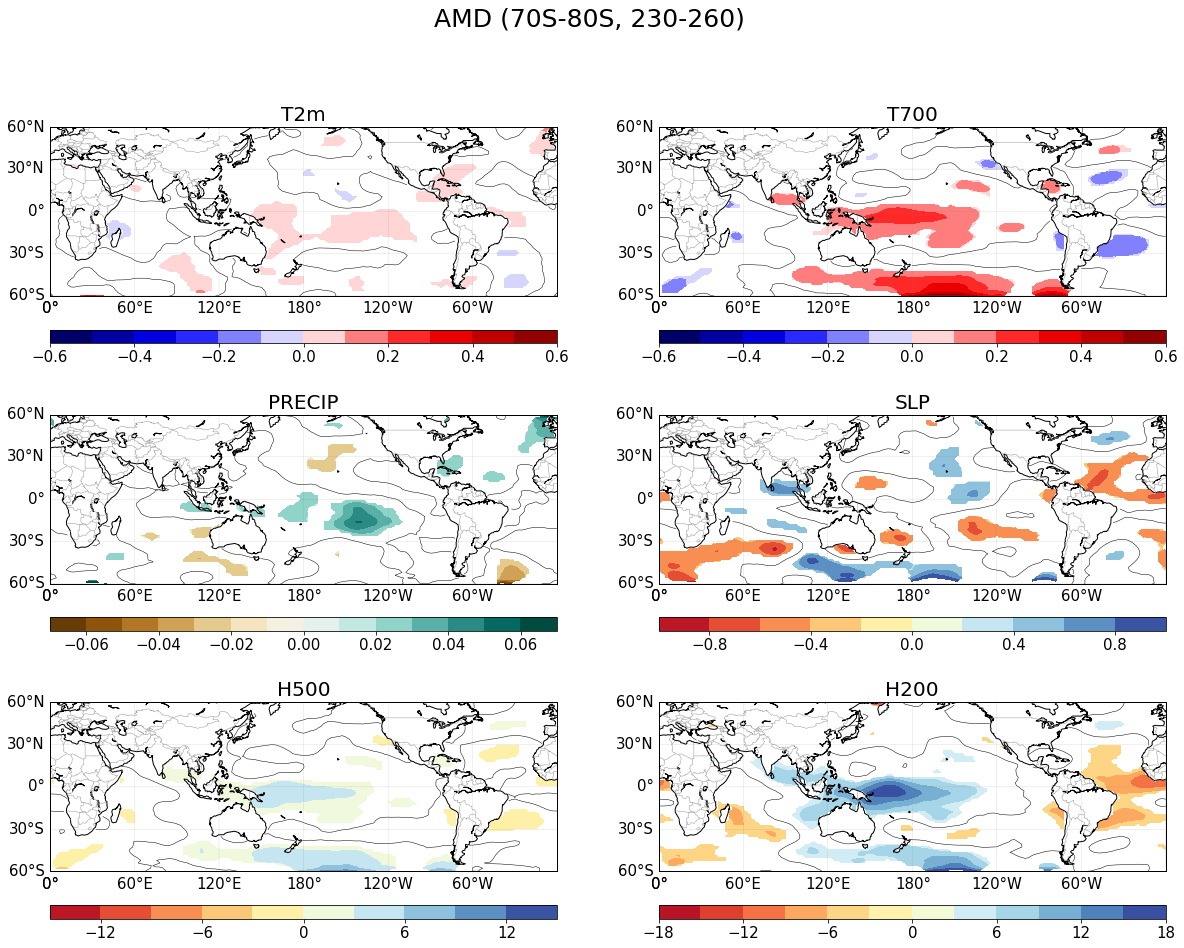

In [24]:
#************************************************
# Plotting GTO map
#************************************************
print "start Basemap"
plot_region = 'AMD'

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20,15))
for i, ax in enumerate(axes.flat):
    ax.set_title(Var[i],size=20)
    m = Basemap(projection='cyl', llcrnrlat=-60, urcrnrlat=60,\
                llcrnrlon=0, urcrnrlon=360, resolution='c', lon_0=180, ax=ax)
    m.drawcoastlines()
    m.drawmapboundary()

    m.drawcountries(color='0.6', linewidth=0.5)
    m.drawparallels(np.arange(-90.,91.,30.),  labels=[1,0,0,1], dashes=[1,1], linewidth=0.25, color='0.5',fontsize=15)
    m.drawmeridians(np.arange(0., 360., 60.), labels=[1,0,0,1], dashes=[1,1], linewidth=0.25, color='0.5',fontsize=15)

    # Make the plot continuous
    K_OLS_cyclic, lons_cyclic           = addcyclic(K_OLS[:,:,GRS.index(plot_region),i], lon)
    K_OLS_mask_cyclic, lons_mask_cyclic = addcyclic(K_OLS_mask[:,:,GRS.index(plot_region),i], lon)

    # Create 2D lat/lon arrays for Basemap
    lon2d, lat2d = np.meshgrid(lons_cyclic, lat)

    # Transforms lat/lon into plotting coordinates for projection
    x, y = m(lon2d, lat2d)

    # Specify colormap range
    if (i <=1):      # T2m, T700
        clevs  = np.linspace(-0.6, 0.6, 13)
        mapp   = plt.cm.seismic
    elif (i == 2):   # Precip
        clevs  = np.linspace(-0.07, 0.07, 15)
        mapp   = plt.cm.BrBG
    elif (i == 3):   # SLP
        clevs  = np.linspace(-1, 1, 11)
        mapp   = plt.cm.RdYlBu
    elif (i == 4):   # H500
        clevs  = np.linspace(-15, 15, 11)
        mapp   = plt.cm.RdYlBu
    elif (i == 5):   # H200
        clevs  = np.linspace(-18, 18, 13)
        mapp   = plt.cm.RdYlBu

    # Specify zero line
    clevs2  = np.linspace(0, 0, 1)

    # Plot filled-contour plot
    cs      = m.contourf(x, y, K_OLS_mask_cyclic, clevs, cmap=mapp)
    # Plot zero-contour line
    contour = m.contour(x, y, K_OLS_cyclic, clevs2, colors = 'k', linestyles = 'solid', linewidths = 0.5)

    # Plot color bar
    cbar    = m.colorbar(cs, "bottom",size="8%", pad="20%") #shrink=0.5
    cbar.ax.tick_params(labelsize=15)
# Save the figure as a pdf file
plt.suptitle(GR[GRS.index(plot_region)],fontsize=25)
#plt.figure(figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.show()
#plt.savefig('GTO_'+GRS[GRS.index(plot_region)]+'_OLS_merge_test.pdf') #, bbox_inches='tight')

# 3. Results
## 3.1 Interpretation of GTO maps
The above plots shows sensitivity of climate variables (i.e. T2m)
* 
*  
